In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import ascii
from astropy import constants as const

# some kind of reading in will occur here
# for now i think i might just use some wikipedia stats...
# or wait until shane gets back to me with his data for me to read from

#amcvn_binaryDATfile.dat
filename = open('binary.dat','r')
dummy = pd.read_csv('binary.dat', delim_whitespace=False, comment='#', header=None)
print(dummy)

# the new commands were being super finicky so im doing this college python course style
# super not optomized! but i can get to that later once i know stuff works

datalist = []
amcvn = filename.readlines()
amcvn
for item in amcvn:
    equals = item.index('=')
    datalist.append(item[equals+2:-1])
datalist

                               0
0   basename  = naomiTest_1orbit
1             a (AU)    = 0.0010
2               ecc       = 0.75
3                inc (deg) = 0.0
4                m1 (msun) = 0.5
5                m2 (msun) = 0.5
6           R (pc)    = 1.000000
7                thN (deg) = 0.0
8                thP (deg) = 0.0
9                phi (deg) = 0.0
10            th1 (deg) = 0.0000
11  tsim (yr) = 3.16875357869e-5
12              Npts      = 1024
13                 fftFlag   = 1


['naomiTest_1orbit',
 '0.0010',
 '0.75',
 '0.0',
 '0.5',
 '0.5',
 '1.000000',
 '0.0',
 '0.0',
 '0.0',
 '0.0000',
 '3.16875357869e-5',
 '1024',
 '1']

In [40]:
# initial condition

tsim = eval(datalist[11]) * 3 #= 6.16 * (10**-5)
tsim = tsim * (3.15*(10**7))
print(tsim)

#masses, switching to SI units aka kg
mass1 = eval(datalist[4])
mass2 = eval(datalist[5])
solarmass = 1.989 * (10**30)
mass1 = mass1 * solarmass
mass2 = mass2 * solarmass
print(mass1)
print(mass2)

#semi-major axis
smajaxis = eval(datalist[1])
aumeter = 1.496 * (10**11)
smajaxis = smajaxis * aumeter
print(smajaxis)

#eccentricity 
ecc = eval(datalist[2])
print(ecc)

#orbital period
g = const.G.value # already in SI
print(g)
initnumer = 4 * (np.pi**2) * (smajaxis**3)
initdenom = (mass1 + mass2) * g
P = np.sqrt(initnumer/initdenom)
print(P)

#rp, for later
rp = smajaxis * (1-ecc)
print(rp)


2994.4721318620495
9.945000000000001e+29
9.945000000000001e+29
149600000.0
0.75
6.6743e-11
997.8310299904202
37400000.0


In [41]:
# the low and high can be found in the file
# can steps be found in the file?
# used variables so i can always edit my times array

low = 0
high = 10000
step = eval(datalist[12])
timeindex = np.linspace(low,tsim,step)
dt = tsim / step
#dt = datalist[11] / step
print(timeindex)
print(dt)

[0.00000000e+00 2.92714773e+00 5.85429547e+00 ... 2.98861784e+03
 2.99154498e+03 2.99447213e+03]
2.9242891912715328


In [4]:
def keqn(manomaly,psi):
    kep = psi- (ecc*np.sin(psi)) - manomaly
    return kep

In [5]:
def bisec(psihigh,psilow,bimanom):
    
    khigh = keqn(bimanom,psihigh)
    klow = keqn(bimanom,psilow)
    tolerance = 0.00001
    
    psinew = psilow + (0.5*(psihigh-psilow))
    knew = keqn(bimanom,psinew)
    
    #print(khigh)
    #print(psihigh)
    #print(klow)
    #print(psilow)
    #print(knew)
    #print(psinew)
    
    if np.sign(klow) > 0 or np.sign(khigh) < 0:
        string = "No Root Possible!"
        return string
    
    while(abs(knew) >= tolerance):
        if np.sign(knew) > 0:
            psihigh = psinew
            #print('down')
        elif np.sign(knew) < 0:
            psilow = psinew
            #print('up')
        psinew = psilow + (0.5*(psihigh-psilow))
        knew = keqn(bimanom,psinew)
        
    if knew < tolerance:
        return psinew

In [6]:
def shapeq(rp,theta):
    r = (rp*(1+ecc)) / (1 + ecc*np.cos(theta))
    return r

In [42]:
# create list that will hold my thetas for each time, maybe by r values too
thetalist = []
rlist = []
xlist = []
ylist = []
plist = []
tlist=[]
currentime = 0
psihi = 1000
psilo = 0
deltapsi = 2

for item in timeindex: 
    # if dt is the step in timeindex
    # then i dont even need to do in range steps
    # i can just do it for each item in the timeindex since that'll change to the correct time each time
    
    currentime = item
    tlist.append(currentime)
    manom = ((2*np.pi)/P)*currentime
     
    # i define my bracket somewhere here
    psirt = bisec(psihi,psilo,manom)
    plist.append(psirt)
    numer = 1+ecc
    denom = 1-ecc
    squareroot = np.sqrt(numer/denom)
    theta = 2*(np.arctan(squareroot*np.tan(psirt/2))) #+ (loop*np.pi)
    #theta = (theta * 180) / np.pi #putting into degrees for SI

    #print("psihigh = " + str(psihi))
    #print("psilow = " + str(psilo))
    #print("root psi = " + str(psirt))
    #print("khi = " + str(keqn(manom,psihi)))
    #print("klo = " + str(keqn(manom,psilo)))
    #print("mean anomaly: " + str(manom))
    #print("current time: " + str(currentime))
    #print("knew = " + str(keqn(manom,psirt)))
    #print('\n')
    
    #adding to my lists
    thetalist.append(theta)
    rlist.append(shapeq(rp,theta))
    xlist.append(shapeq(rp,theta) * np.cos(theta))
    ylist.append(shapeq(rp,theta) * np.sin(theta))
    
    psihi = psilo + deltapsi
    psilo = psirt
    #currentime = ((P*manom) / (2*np.pi))
    #currentime = currentime + dt
    

In [9]:
#print(rlist)
# issue: rlist prints unique numbers up until certain index then they seem to be duplicates
# this therefore carries over to xlist and ylist

<IPython.core.display.Javascript object>


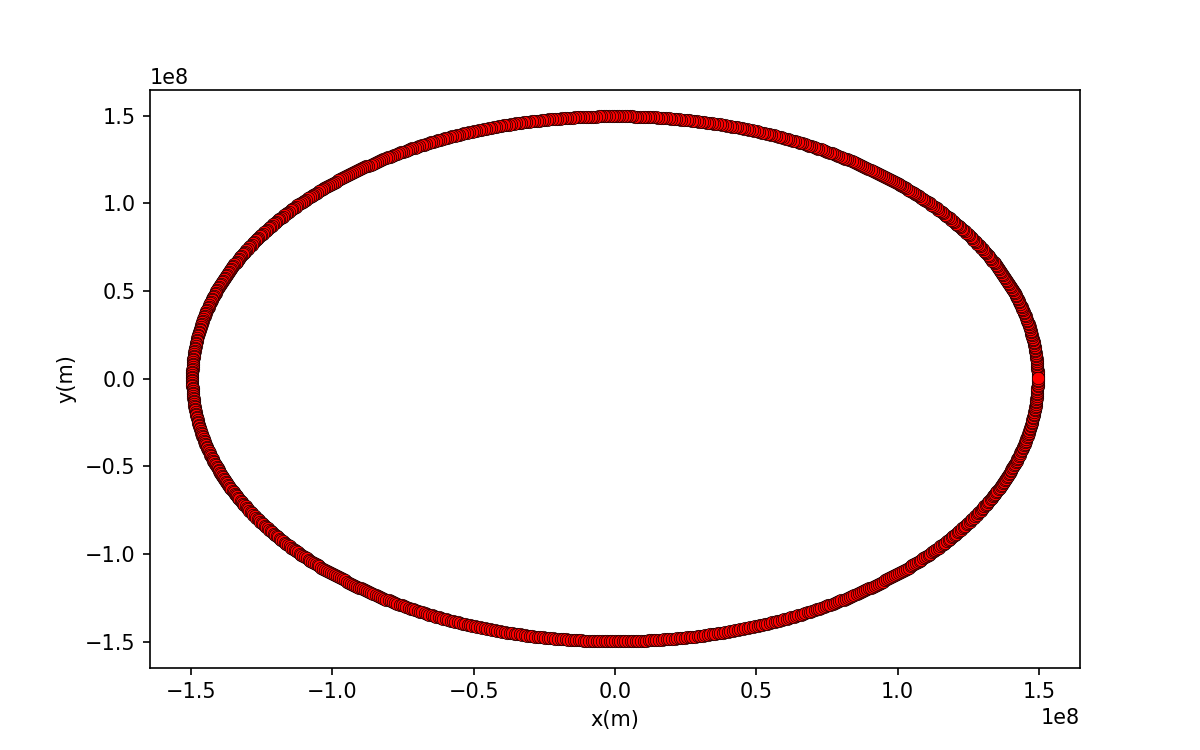

Text(0, 0.5, 'y(m)')

In [8]:
#plotting my orbit
f,ax = plt.subplots(figsize=(8,5))
ax.scatter(xlist,ylist, c='red', linewidths=0.3, edgecolors='k')
ax.set_xlabel("x(m)")
ax.set_ylabel("y(m)")
#ax.set_aspect('equal') #command for to check if it looks right / equal aspect ratio
#ax.set_xlim(-3*(10**8),5*(10**7))
#ax.set_ylim(-3*(10**8),5*(10**8))

1024
1024


<IPython.core.display.Javascript object>


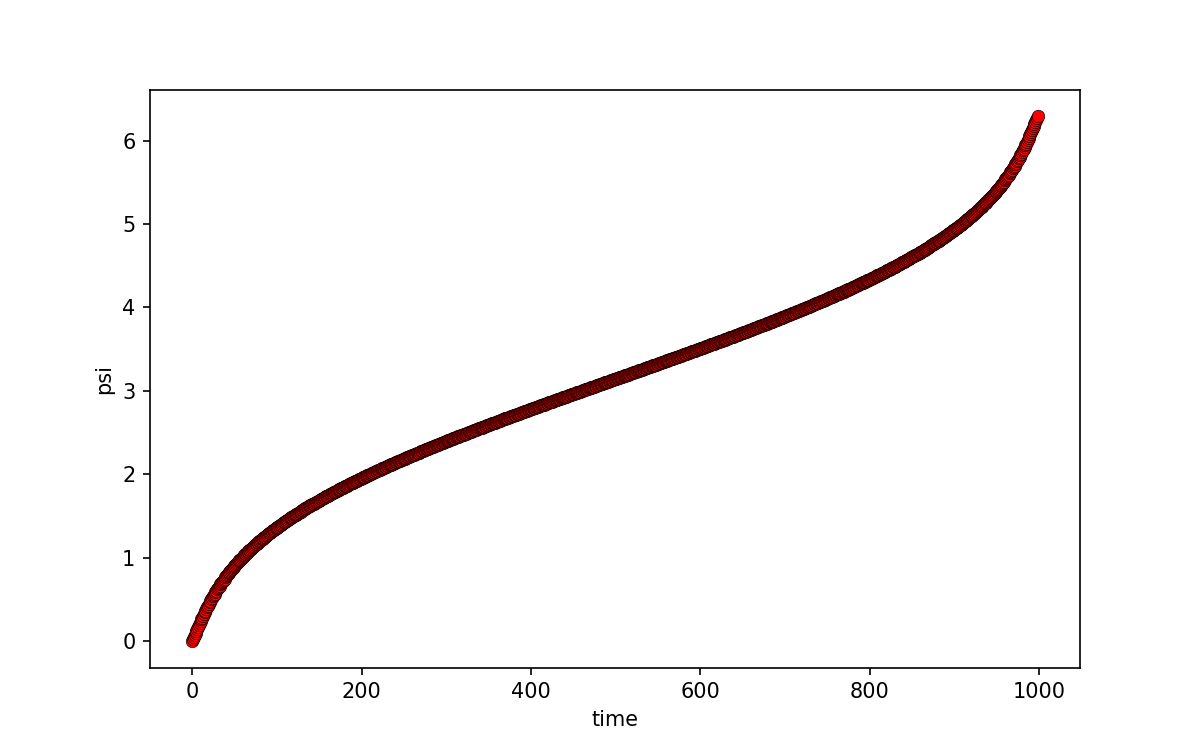

Text(0, 0.5, 'psi')

In [161]:
print(len(plist))
print(len(tlist))
f,ax = plt.subplots(figsize=(8,5))
ax.scatter(tlist,plist, c='red', linewidths=0.3, edgecolors='k')
ax.set_xlabel("time")
ax.set_ylabel("psi")

<IPython.core.display.Javascript object>


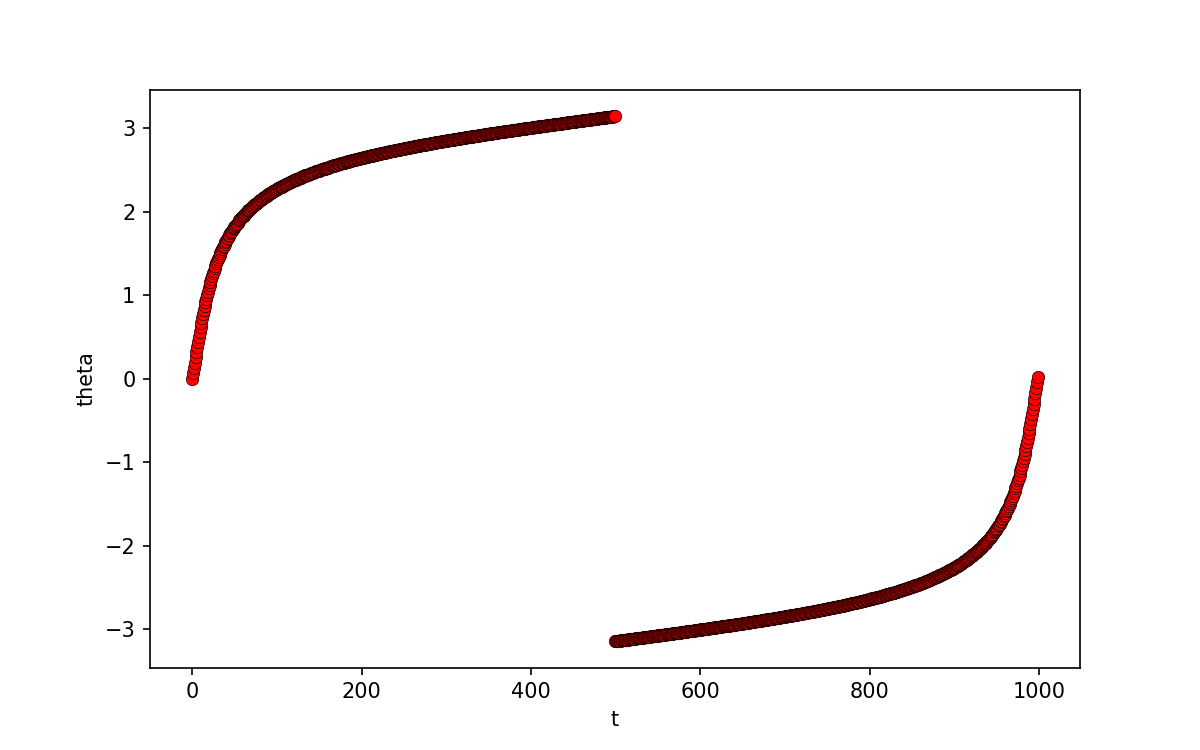

Text(0, 0.5, 'theta')

In [162]:
f,ax = plt.subplots(figsize=(8,5))
ax.scatter(tlist,thetalist, c='red', linewidths=0.3, edgecolors='k')
ax.set_xlabel("t")
ax.set_ylabel("theta")

<IPython.core.display.Javascript object>


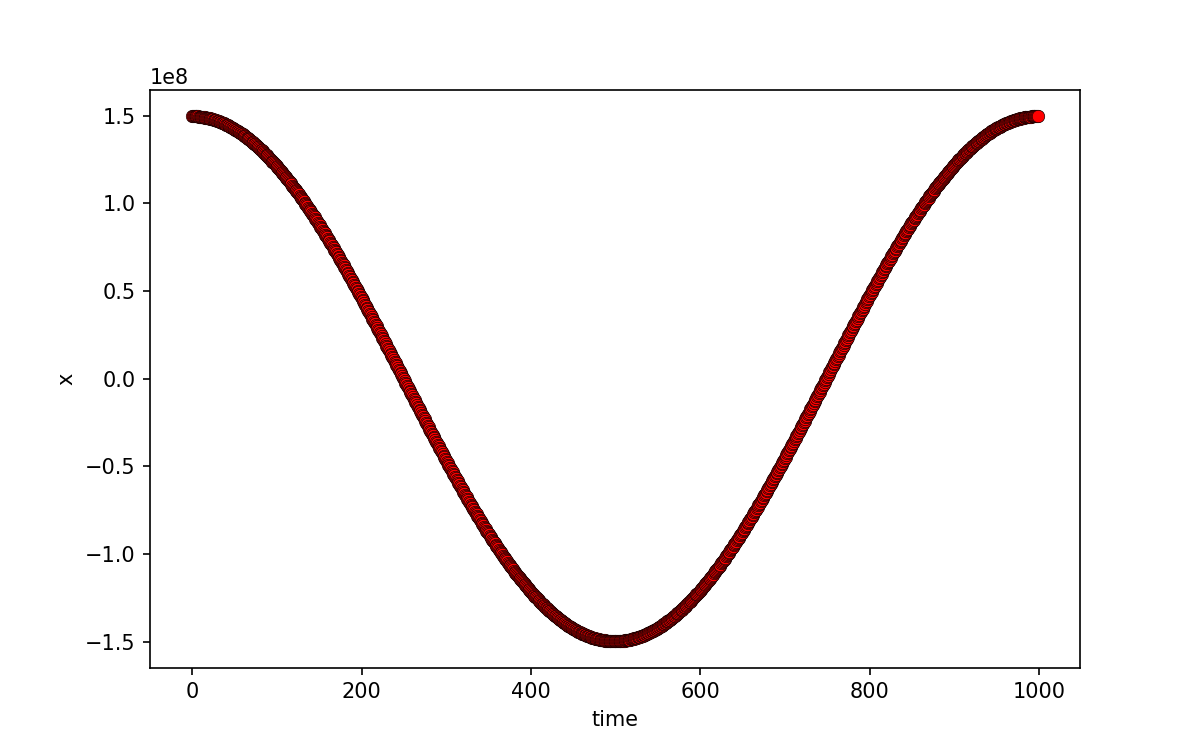

Text(0, 0.5, 'x')

In [23]:
f,ax = plt.subplots(figsize=(8,5))
ax.scatter(tlist,xlist, c='red', linewidths=0.3, edgecolors='k')
ax.set_xlabel("time")
ax.set_ylabel("x")

<IPython.core.display.Javascript object>


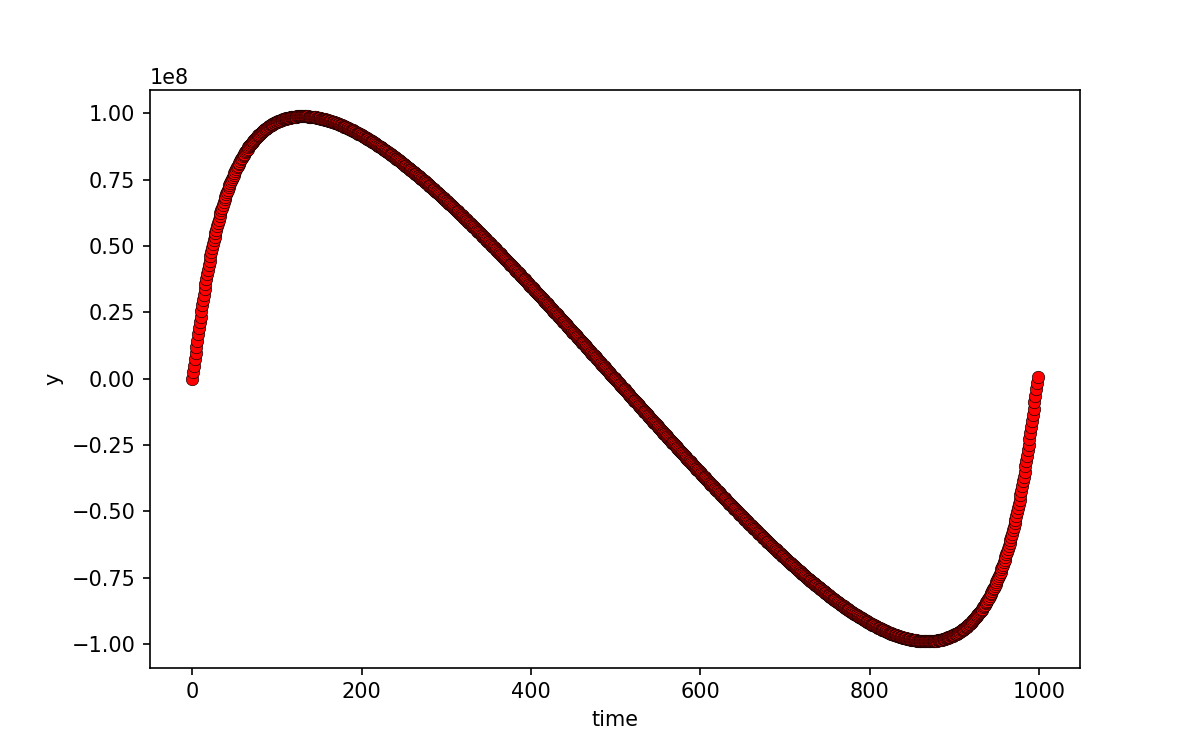

Text(0, 0.5, 'y')

In [49]:
f,ax = plt.subplots(figsize=(8,5))
ax.scatter(tlist,ylist, c='red', linewidths=0.3, edgecolors='k')
ax.set_xlabel("time")
ax.set_ylabel("y")

In [43]:
# starting the second part of the project
# mytime = 100 #the time we want to use >>> is this something shane gave me a default for?
mytheta = tlist[0]
print(mytheta)

# any constant values
c = const.c.value
D = eval(datalist[6]) 
phi = eval(datalist[9])
inc = eval(datalist[3])
thetan = eval(datalist[7])
thetap = eval(datalist[8])

# to SI and radians
D = D * (3.0857 * (10**16))
phi = (phi * np.pi) / 180
inc = (inc * np.pi) / 180
thetan = (thetan * np.pi) / 180
thetap = (thetap * np.pi) / 180

# printing constants
print("Constant c = " + str(c))
print("Constant D = " + str(D))
print("Constant phi = " + str(phi))
print("Constant inc = " + str(inc))
print("Constant thetan = " + str(thetan))
print("Constant thetap = " + str(thetap))


0.0
Constant c = 299792458.0
Constant D = 3.0857e+16
Constant phi = 0.0
Constant inc = 0.0
Constant thetan = 0.0
Constant thetap = 0.0


In [44]:
# coefficient values
# does sin2() thing mean 2*theta or 2*sin value?
# i feel like its 2*theta, otherwise the number would be out in front
print(g)

Hterm = smajaxis*(1-(ecc**2))
H = (4*(g**2)*mass1*mass2) / ((c**4)*Hterm*D)
A0 = -0.5 * (1+(np.cos(inc)**2)) * np.cos(2*(mytheta-thetan))
B0 = -1 * np.cos(inc) * np.sin(2*(mytheta-thetan))
A1 = (0.25 * (np.sin(inc)**2) * np.cos(mytheta-thetap)) - (0.125 * (1 + (np.cos(inc)**2)) * (5 * np.cos(mytheta-(2*thetan)+thetap) + np.cos((3*mytheta)-(2*thetan)-thetap)))
B1 = -0.25 * np.cos(inc) * (5 * np.sin(mytheta-(2*thetan)+thetap) + np.sin((3*mytheta)-(2*thetan)-thetap))
A2 = 0.25 * (np.sin(inc)**2) - 0.25 * (1+(np.cos(inc)**2)) * np.cos((2*thetan) - (2*thetap))
B2 = 0.5 * np.cos(inc) * np.sin((2*thetan) - (2*thetap))

# printing values
print("H = " + str(H))
print("A0 = " + str(A0))
print("B0 = " + str(B0))
print("A1 = " + str(A1))
print("B1 = " + str(B1))
print("A2 = " + str(A2))
print("B2 = " + str(B2))

6.6743e-11
H = 1.0802763054091576e-18
A0 = -1.0
B0 = -0.0
A1 = -1.5
B1 = -0.0
A2 = -0.5
B2 = 0.0


In [45]:
# writing out the h equations

# h plus
hpfirst = (np.cos(2*phi)) * (A0 + (ecc*A1) + ((ecc**2)*A2))
print(hpfirst)
hpsecond = (np.sin(2*phi)) * (B0 + (ecc*B1) + ((ecc**2)*B2))
hp = H * (hpfirst - hpsecond)

# h cross
hxfirst = (np.sin(2*phi)) * (A0 + (ecc*A1) + ((ecc**2)*A2))
hxsecond = (np.cos(2*phi)) * (B0 + (ecc*B1) + ((ecc**2)*B2))
print(hxsecond)
hx = H * (hxfirst + hxsecond)

# printing values
print(hp)
print(hx)

-2.40625
0.0
-2.5994148598907854e-18
0.0


In [46]:
# that was writing it with just one theta value, given by the user
# presumably i need a loop to 
hplist = []
hxlist = []

for value in thetalist:
    
    #get theta and coeffs 
    mytheta = value
    A0 = -0.5 * (1+(np.cos(inc)**2)) * np.cos(2*(mytheta-thetan))
    B0 = -1 * np.cos(inc) * np.sin(2*(mytheta-thetan))
    A1 = (0.25 * (np.sin(inc)**2) * np.cos(mytheta-thetap)) - (0.125 * (1 + (np.cos(inc)**2)) * (5 * np.cos(mytheta-(2*thetan)+thetap) + np.cos((3*mytheta)-(2*thetan)-thetap)))
    B1 = -0.25 * np.cos(inc) * (5 * np.sin(mytheta-(2*thetan)+thetap) + np.sin((3*mytheta)-(2*thetan)-thetap))
    A2 = 0.25 * (np.sin(inc)**2) - 0.25 * (1+(np.cos(inc)**2)) * np.cos((2*thetan) - (2*thetap))
    B2 = 0.5 * np.cos(inc) * np.sin((2*thetan) - (2*thetap))
    
    # solve h equations
    
    # h plus
    hpfirst = (np.cos(2*phi)) * (A0 + (ecc*A1) + ((ecc**2)*A2))
    hpsecond = (np.sin(2*phi)) * (B0 + (ecc*B1) + ((ecc**2)*B2))
    hp = H * (hpfirst - hpsecond)
    hplist.append(hp)

    # h cross
    hxfirst = (np.sin(2*phi)) * (A0 + (ecc*A1) + ((ecc**2)*A2))
    hxsecond = (np.cos(2*phi)) * (B0 + (ecc*B1) + ((ecc**2)*B2))
    hx = H * (hxfirst + hxsecond)
    hxlist.append(hx)
    
#print(hplist)
#print('\n')
#print(hxlist)

    

<IPython.core.display.Javascript object>


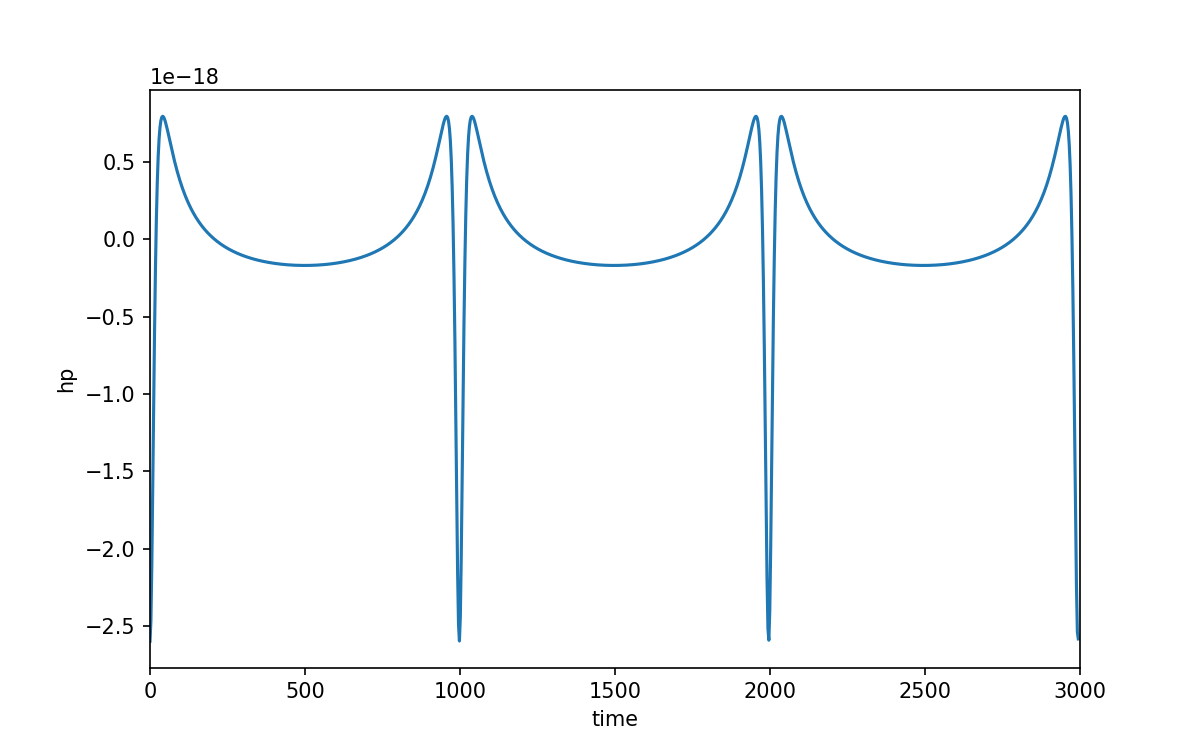

(0.0, 3000.0)

In [47]:
# plot hp vs t, should look like sinusoid
f,ax = plt.subplots(figsize=(8,5))
ax.plot(tlist,hplist) #c='red', linewidths=0.3, edgecolors='k')
ax.set_xlabel("time")
ax.set_ylabel("hp")
ax.set_xlim(0,3000)

<IPython.core.display.Javascript object>


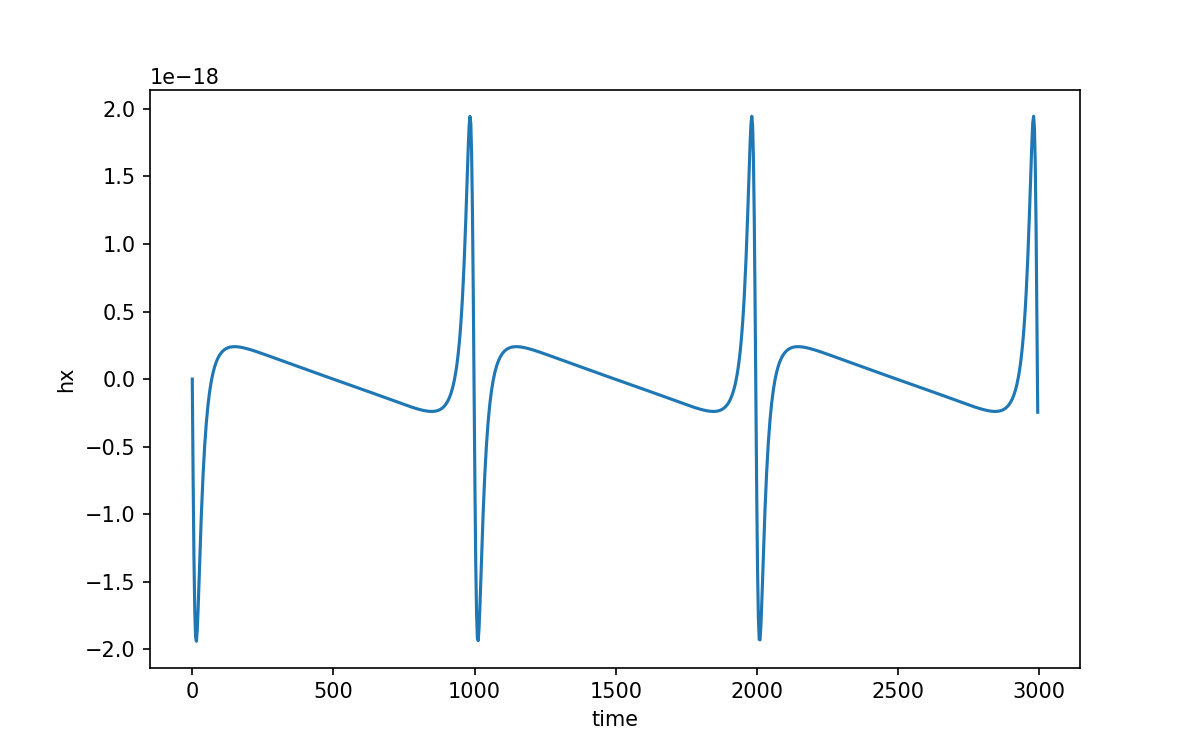

Text(0, 0.5, 'hx')

In [49]:
# plot hx vs t, should look like sinusoid
f,ax = plt.subplots(figsize=(8,5))
ax.plot(tlist,hxlist) #c='red', linewidths=0.3, edgecolors='k')
ax.set_xlabel("time")
ax.set_ylabel("hx")

In [60]:
print(hplist[400]) 
print(hxlist[400])
print(len(hplist))
print(len(timeindex))

-5.3313874416961576e-20
-4.696042274352944e-19
1024
1024


In [73]:
counter = 1
indexlist = []
for values in range(len(timeindex)):
    indexlist.append(counter)
    counter+=1
    
indexprint = indexlist
timeprint = timeindex
hpprint = hplist
hxprint = hxlist

titles = ['index','time','hp','hx']
data = [titles] + list(zip(indexprint,timeprint,hpprint,hxprint))

for i,d in enumerate(data):
    line = ''.join(str(x).ljust(25) for x in d)
    print(line)

index                    time                     hp                       hx                       
1                        0.0                      -4.726208836165064e-19   0.0                      
2                        0.9757159113268328       1.7558364772423996e-19   -4.387948065808178e-19   
3                        1.9514318226536655       3.4215852608274264e-19   3.260338060068808e-19    
4                        2.9271477339804983       -4.298146569417905e-19   1.9654480483711146e-19   
5                        3.902863645307331        -2.2797160864616107e-20  -4.720707458495602e-19   
6                        4.878579556634164        4.467534288036515e-19    1.5421372663491393e-19   
7                        5.854295467960997        -3.091500694922485e-19   3.574866908898641e-19    
8                        6.830011379287829        -2.1704839977367546e-19  -4.198338859431597e-19   
9                        7.805727290614662        4.704216132858754e-19    -4.5541249257805

1019                     993.2787977307157        -2.2648611486756536e-19  -4.1481868256220487e-19  
1020                     994.2545136420426        4.692715651733615e-19    -5.616669609466866e-20   
1021                     995.2302295533694        -1.2219256626015949e-19  4.565517236646948e-19    
1022                     996.2059454646962        -3.784799084671784e-19   -2.830608742251806e-19   
1023                     997.181661376023         4.0341112947928325e-19   -2.462315175656769e-19   
1024                     998.15737728735          7.873692163794209e-20    4.660160907108551e-19    
